# TASK 1: PROJECT OVERVIEW

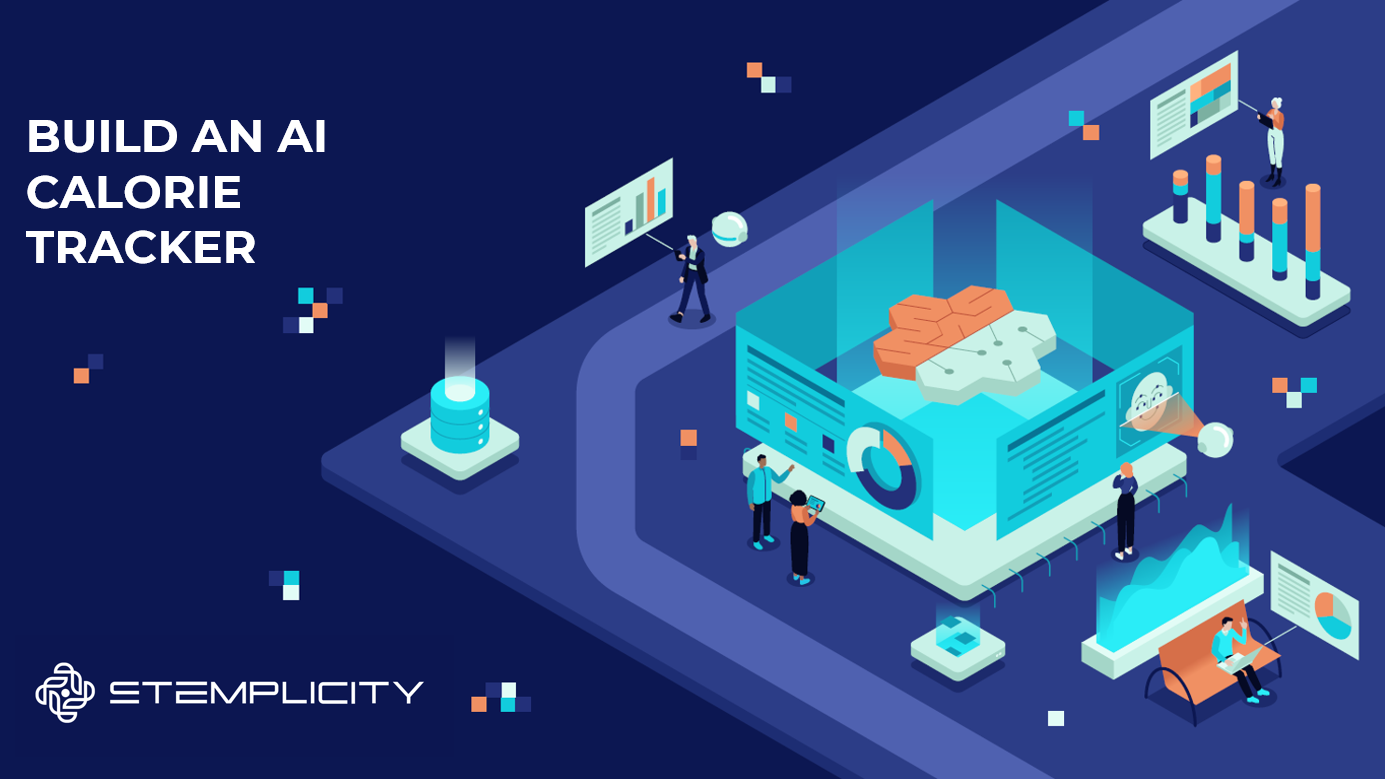

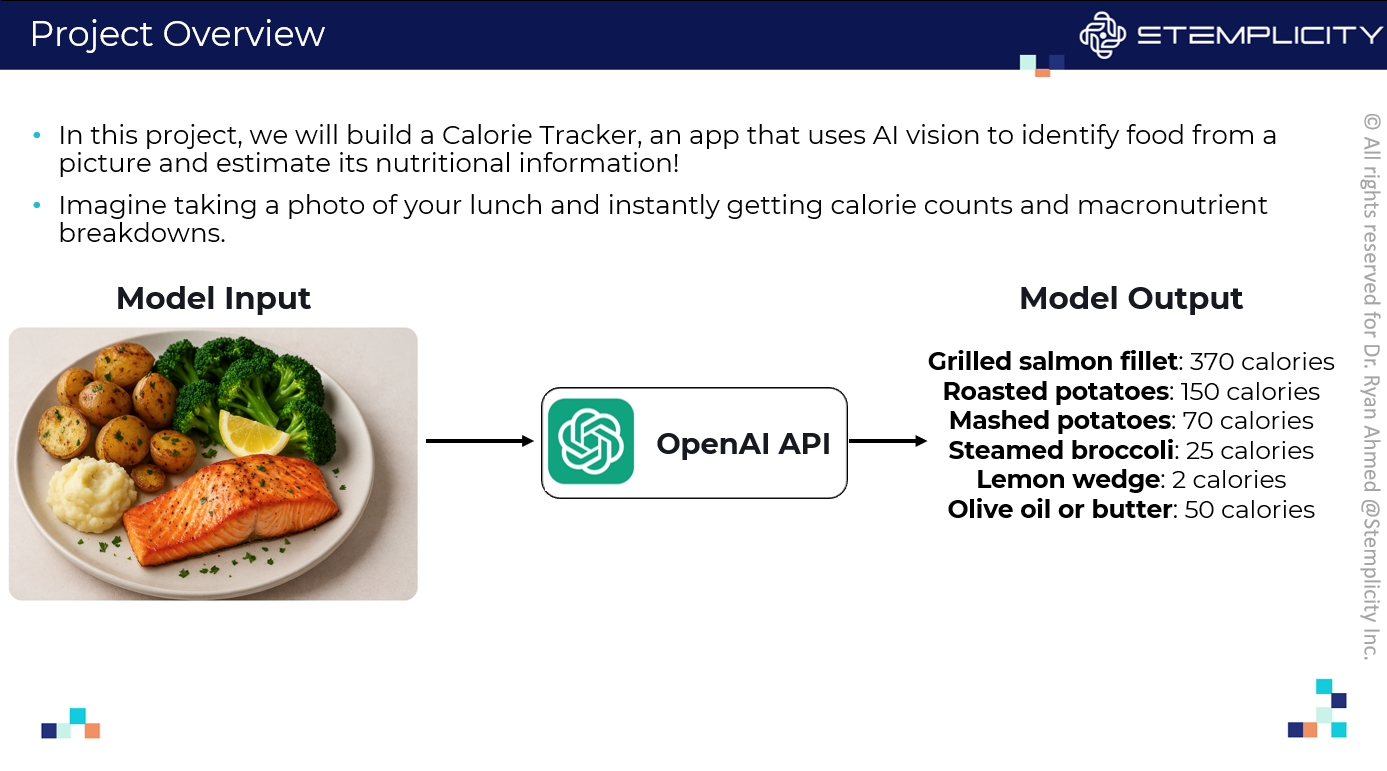

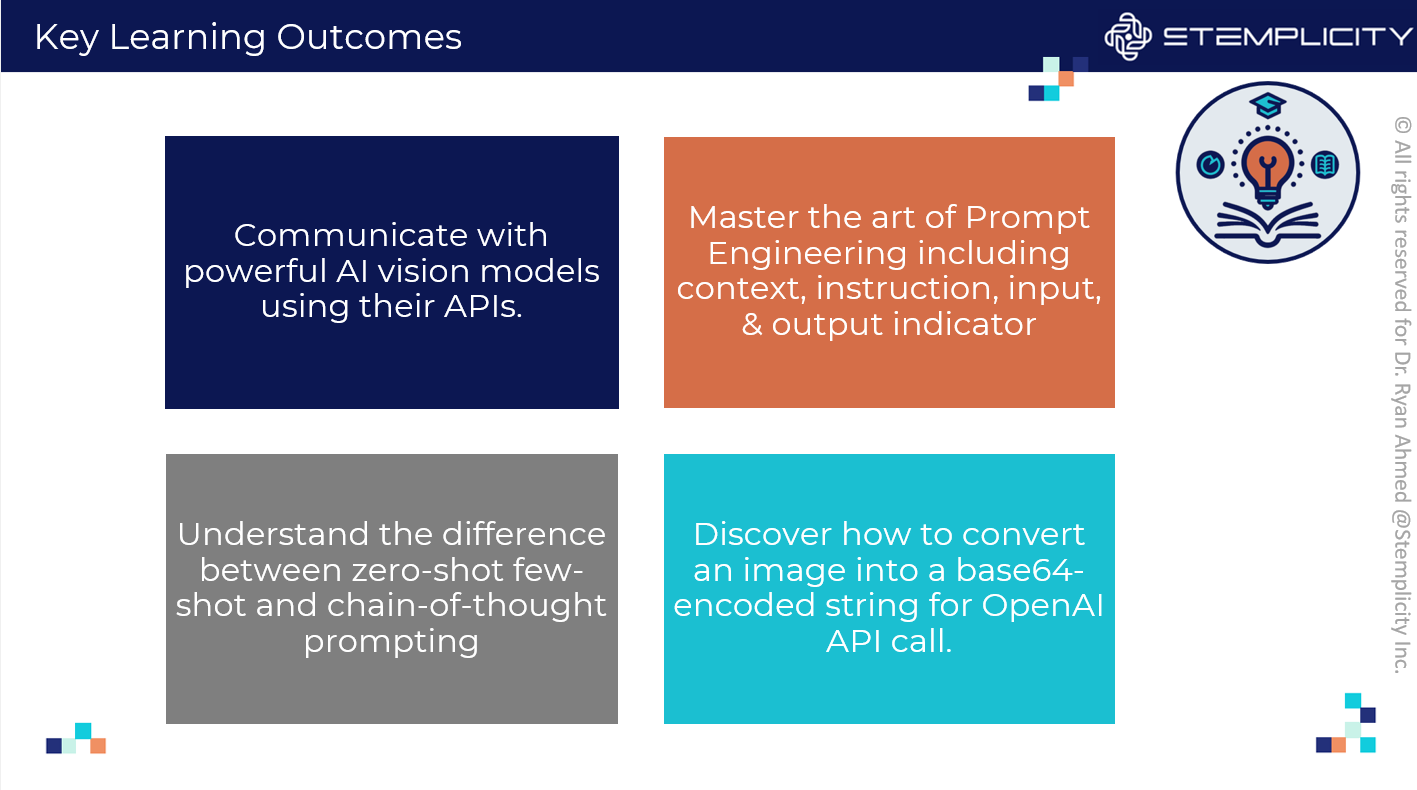

# TASK 2.LET'S READ A SAMPLE IMAGE

In [1]:
# Let's install and import OpenAI Package
!pip install --upgrade openai
from openai import OpenAI  

# Let's import os Python module, which stands for "Operating System"
# The os module lets you interact with your computer’s operating system
import os

# This will be used to load the API key from the .env file
from dotenv import load_dotenv
load_dotenv()

# Get the OpenAI API keys from environment variables
openai_api_key = os.getenv("OPENAI_API_KEY")

# Let's configure the OpenAI Client using our key
openai_client = OpenAI(api_key = openai_api_key)
print("OpenAI client successfully configured.")

# Let's view the first few characters in the key
print(openai_api_key[:15])

OpenAI client successfully configured.
sk-proj-H3dZxa9


In [2]:
# Define a helper function named "print_markdown" to display markdown
from IPython.display import display, Markdown  

def print_markdown(text):
    """Displays text as Markdown in Jupyter."""
    display(Markdown(text))

In [3]:
# Let's try loading and displaying a sample image
# Before sending images to OpenAI API, we need to learn how to load and view them in our notebook
# We'll use the Pillow library (imported as PIL) for this task

# Import Pillow for image handling
from PIL import Image  

Image 'images/food_image.jpg' loaded successfully.
Format: JPEG
Size: (600, 400)
Mode: RGB


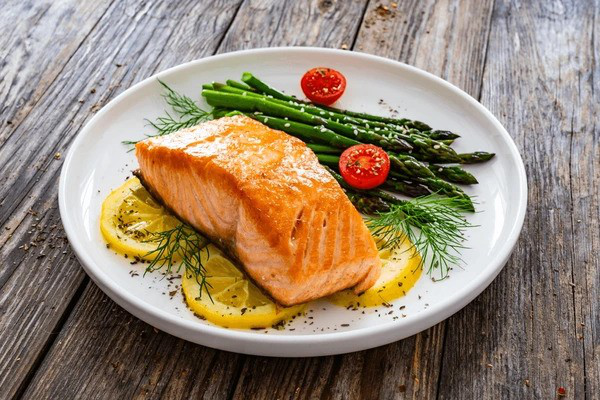

In [4]:
# IMPORTANT: Replace this with the path to your downloaded image file
# Make sure the image file is in the same directory as the notebook
image_filename = "images/food_image.jpg"  # <--- CHANGE THIS to your image file name

# Use Pillow's Image.open() to load the image from the file
img = Image.open(image_filename)
print(f"Image '{image_filename}' loaded successfully.")
print(f"Format: {img.format}")
print(f"Size: {img.size}")
print(f"Mode: {img.mode}")

# Use IPython.display to show the image directly in the notebook output
display(img)

# Keep the loaded image object in a variable for later use
image_to_analyze = img


**PRACTICE OPPORTUNITY:**
- **Download another food image (e.g., a banana, a slice of pizza) and save it to your project folder. Update the `image_filename` variable in the code cell above to the new filename and run the cell again. Does it load and display correctly?**
- **Look at the printed output for the `Format`, `Size`, and `Mode` of your images.**

# TASK 3. UNDERSTAND PROMPT ENGINEERING FUNDAMENTALS

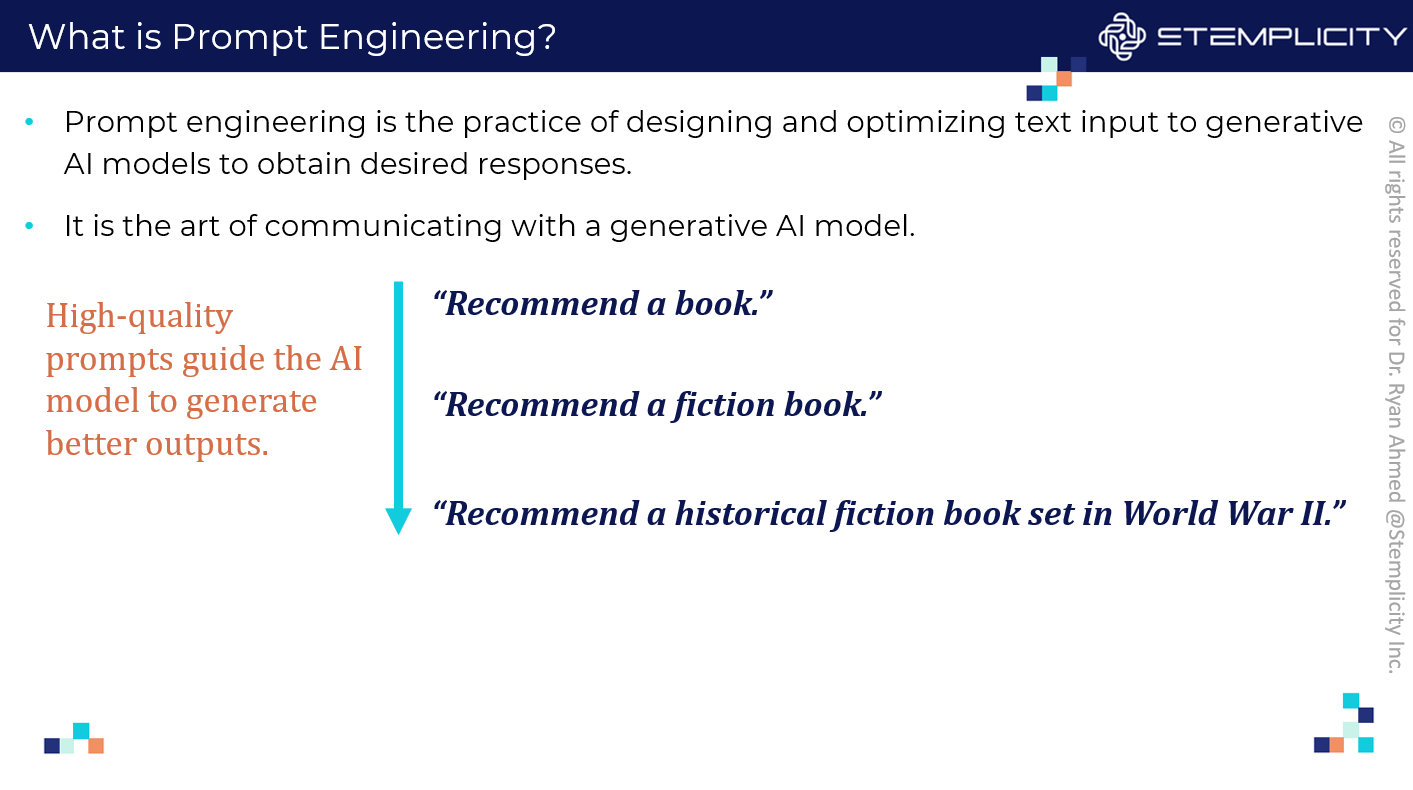

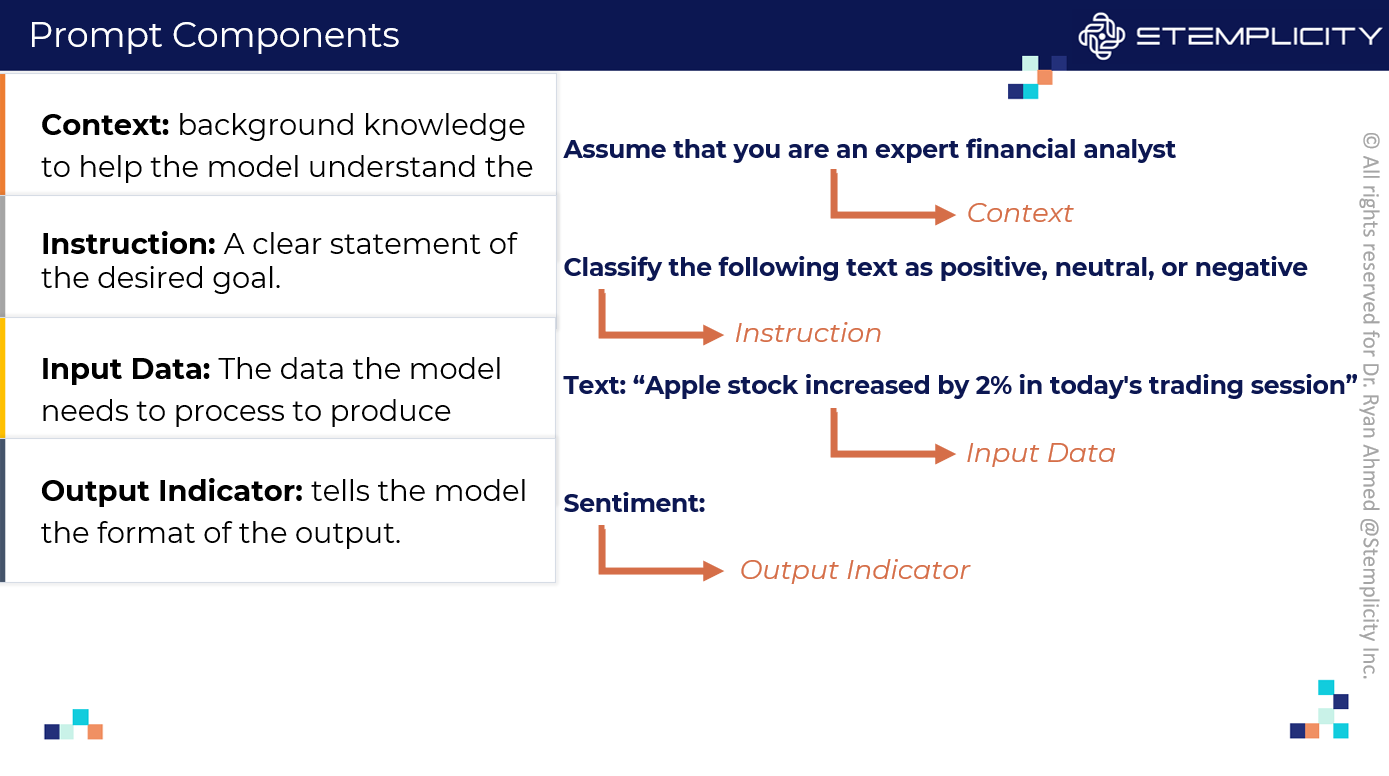

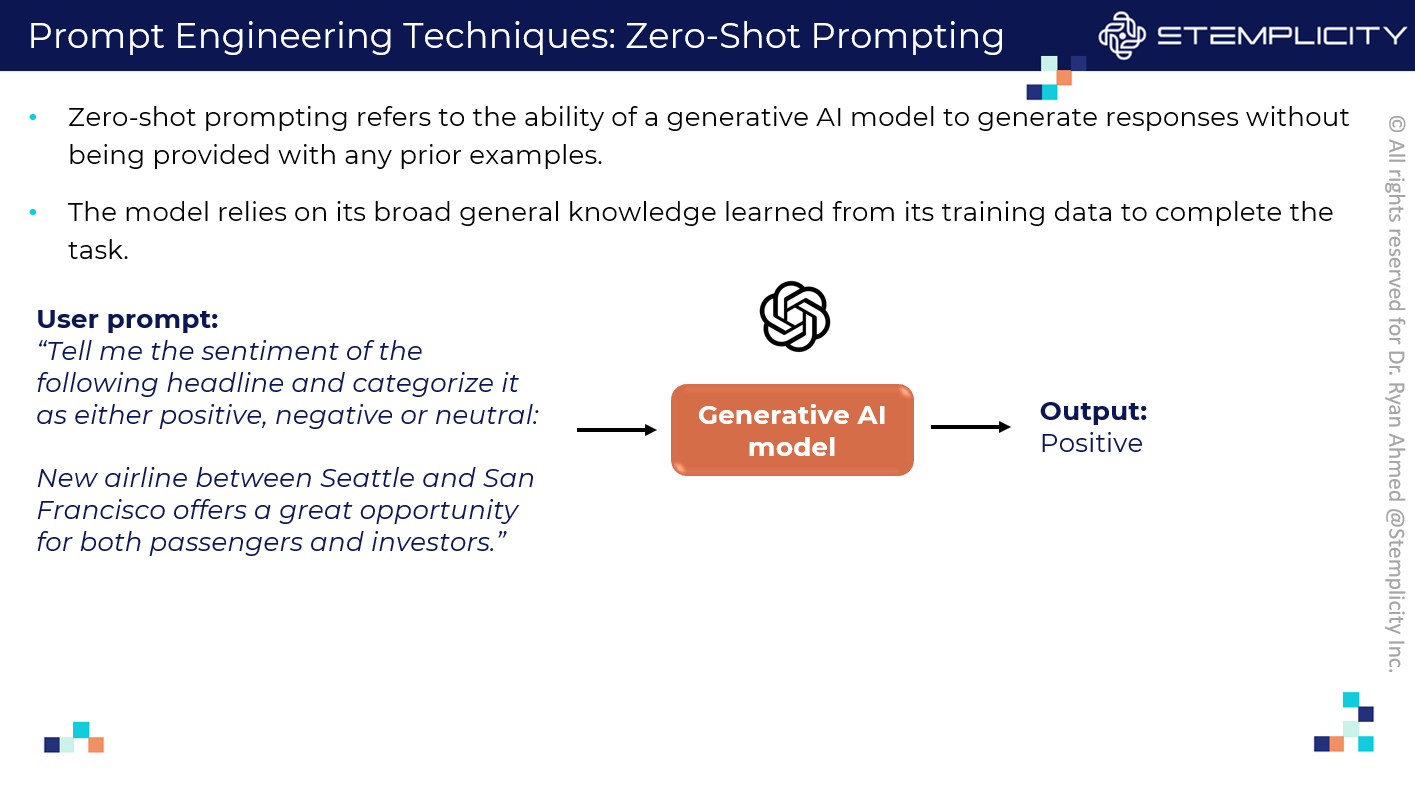

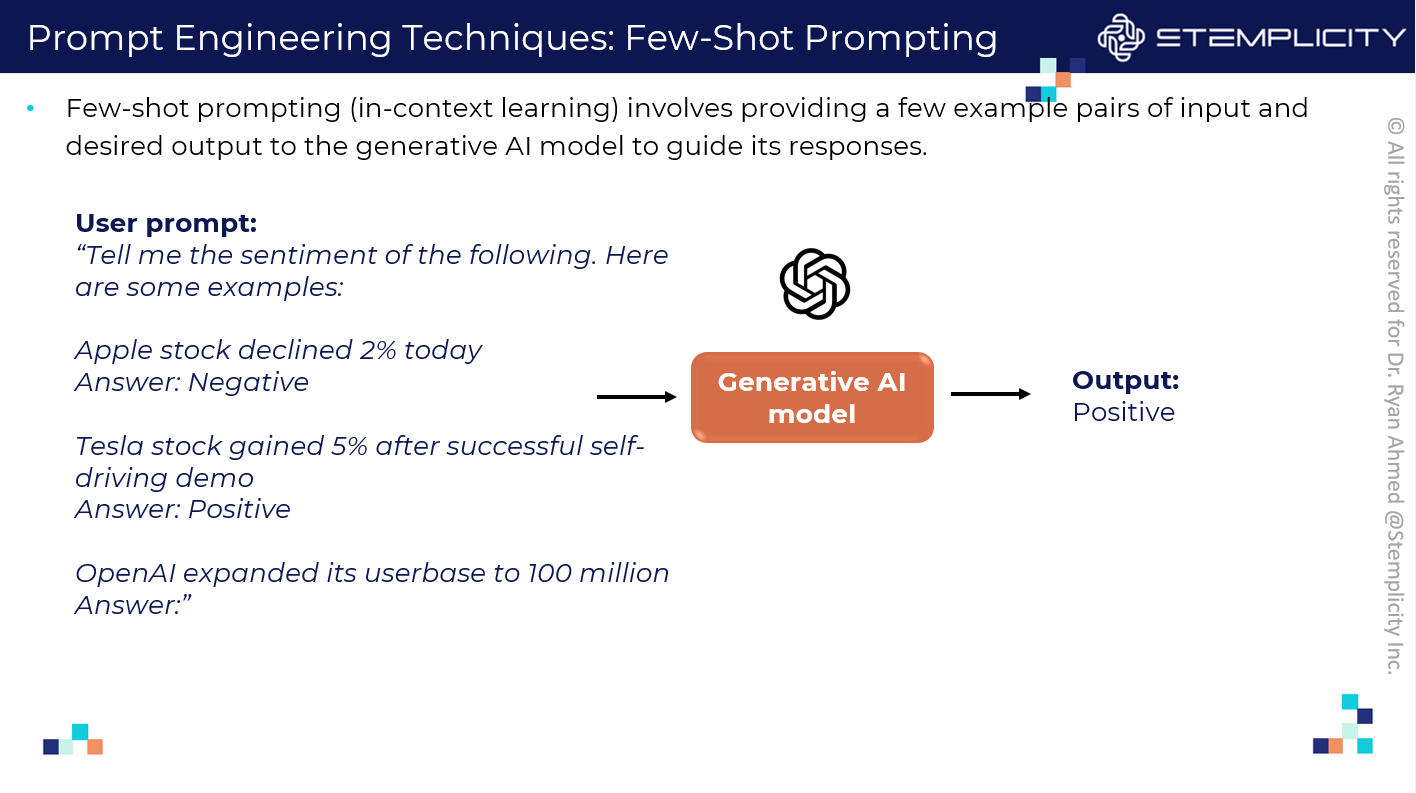

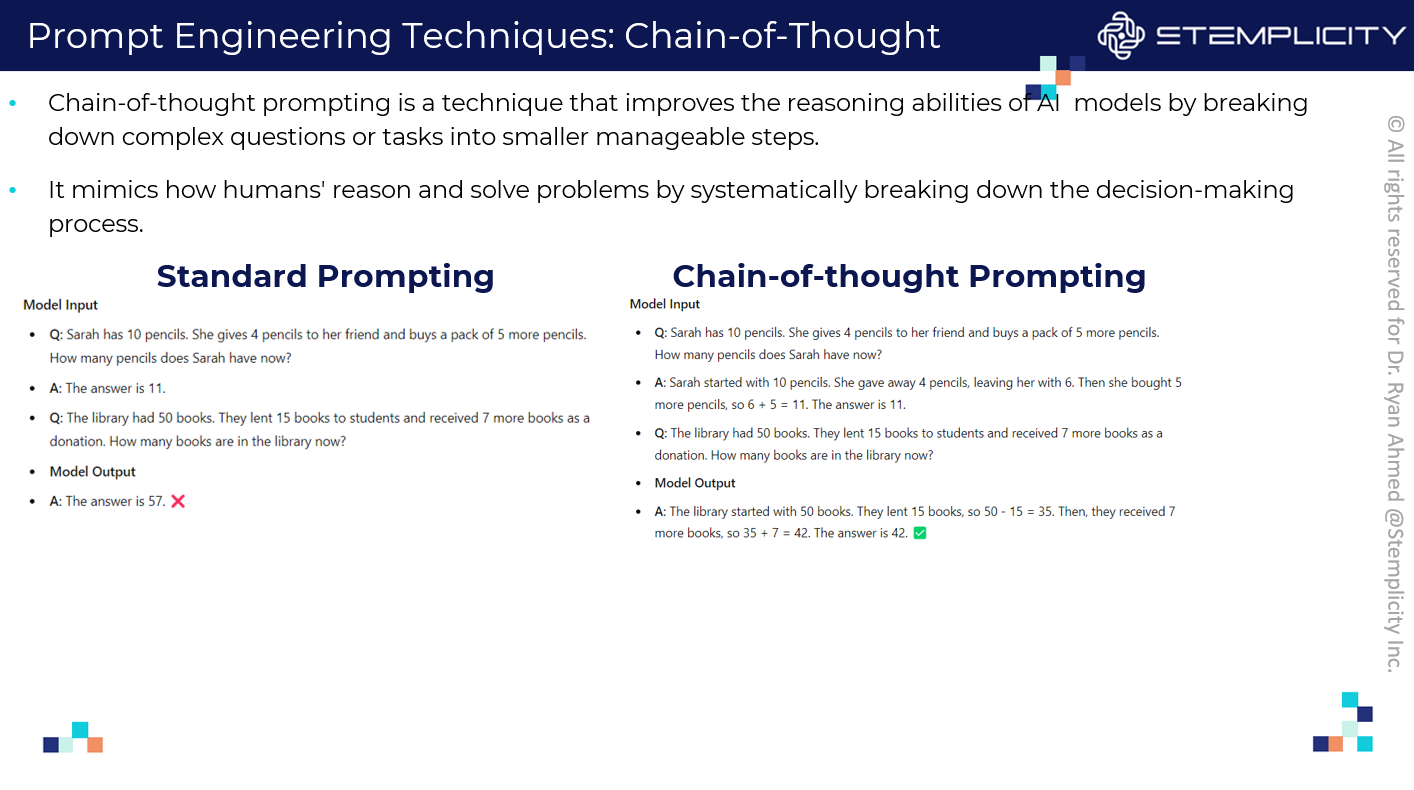

**PRACTICE OPPORTUNITY:**
- **BlackRock private equity investment firm receives financial reports, earnings call transcripts, and analyst notes on potential portfolio companies. The goal is to automate the extraction of key financial metrics, market sentiment, and strategic risks. You have received an earnings call transcript for a potential acquisition company, "SolidPower Inc.".**
    - **Draft a prompt that classifies the CEO's tone as optimistic, cautious, or concerning based on key phrases. Design the prompt to have context, instruction, input, and output indicator**
    - **Highlight the top 3 phrases that influenced this classification and include actionable recommendations**
    - **Test the prompt using any generative AI model such as ChatGPT, CoPilot, Gemini, or Claude. (No code is required for this practice opportunity)** 

```text

"Operator: Good morning, and welcome to Solid Power's Fourth Quarter 2024 Earnings Conference Call. At this time, all participants are in a listen-only mode. After management’s prepared remarks, we will open the call for questions. I would now like to turn the call over to our CEO, Mark Reynolds. Please go ahead.
CEO Mark Reynolds: Thank you, and good morning, everyone. I’m pleased to share our results for Q4 2024 and our outlook for the year ahead. Despite ongoing macroeconomic uncertainties, Solid Power posted strong revenue
growth of 8.2% year-over-year, reaching $420 million for the quarter. This marks our ninth consecutive quarter of revenue expansion, driven by continued demand for high-performance air suspension systems and strategic investments in supply chain resilience.
Key Highlights:
- Gross margin expanded to 42.1%, reflecting improved production efficiency and favourable pricing strategies.
- EBITDA came in at $78.5 million, a 6.5% increase from last year.
- Net income for the quarter was $24.8 million, or $1.35 per share, up from $1.20 per share in Q3 2024.
- Cash flow from operations totalled $50 million, reinforcing our strong liquidity
position.





# TASK 4. LET'S PERFORM IMAGE RECONGITION USING OPENAI'S VISION API

Let the magic begin! 

Let's send our loaded image to OpenAI's GPT Vision model and ask a simple question: "What food is in this image?"

OpenAI requires images to be sent either as a URL or as a base64-encoded string. We'll use base64 encoding for local files. The image is part of the `messages` list.


In [11]:
# The io module in Python provides tools for working with streams of data
# like reading from or writing to files in memory
import io  

# Used for encoding images for OpenAI's API
import base64  

In [13]:
# This function converts an image into a special text format (called base64)
# This is used if we want to send an image to OpenAI’s API

# This function works with two types of inputs: 
# (1) A file path: a string that tells the function where the image is stored on your computer.
# (2) An image object: a photo already loaded in memory using the PIL library (Python Imaging Library).

def encode_image_to_base64(image_path_or_pil):
    if isinstance(image_path_or_pil, str):  # If it's a file path
        # Check if the file exists
        if not os.path.exists(image_path_or_pil):
            raise FileNotFoundError(f"Image file not found at: {image_path_or_pil}")
        with open(image_path_or_pil, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")
            
    elif isinstance(image_path_or_pil, Image.Image):  # If it's a PIL Image object
        buffer = io.BytesIO()
        image_format = image_path_or_pil.format or "JPEG"  # Default to JPEG if format unknown
        image_path_or_pil.save(buffer, format=image_format)
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError("Input must be a file path (str) or a PIL Image object.")


In [15]:
# Let's define a function that queries OpenAI's vision model with an image
def query_openai_vision(client, image, prompt, model = "gpt-4o", max_tokens = 100):
    """
    Function to query OpenAI's vision model with an image
    
    Args:
        client: The OpenAI client
        image: PIL Image object to analyze
        prompt: Text prompt to send with the image
        model: OpenAI model to use (default: gpt-4o)
        max_tokens: Maximum tokens in response (default: 100)
        
    Returns:
        The model's response text or an error message
    """

    # Encode the image to base64
    base64_image = encode_image_to_base64(image)
    
    try:
        # Construct the message payload
        messages = [
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        },
                    },
                ],
            }
        ]

        # Make the API call
        response = client.chat.completions.create(
            model = model,
            messages = messages,
            max_tokens = max_tokens,
        )

        # Extract the response
        return response.choices[0].message.content
    
    except Exception as e:
        return f"Error calling API: {e}"

In [17]:
# Let's define our text prompt that will be sent with the image
food_recognition_prompt = """
Context: I'm analyzing a food image for a calorie-tracking application.
Instruction: Please identify the food item in this image.
Input: [The image I'm about to share]
Output: Provide the name of the food, a brief description of what you see, and if possible, mention its typical ingredients or nutritional profile.
"""
print(f"{food_recognition_prompt}")


Context: I'm analyzing a food image for a calorie-tracking application.
Instruction: Please identify the food item in this image.
Input: [The image I'm about to share]
Output: Provide the name of the food, a brief description of what you see, and if possible, mention its typical ingredients or nutritional profile.



In [23]:
# Let's call the function and send it an image!
print("🤖 Querying OpenAI Vision...")
openai_description = query_openai_vision(
    openai_client, 
    image_to_analyze, 
    food_recognition_prompt
)
print_markdown(openai_description)


🤖 Querying OpenAI Vision...


This food appears to be savory. The colors in the image include orange (salmon), green (asparagus and herbs), red (cherry tomatoes), and yellow (lemon slices).

**PRACTICE OPPORTUNITY:**
- **Modify the `food_recognition_prompt` variable in the code above. Ask a different question, like `"What is the main color of the food in this image?"` or `"Is this food likely sweet or savory?"`. Run the cell again and perform a sanity check on OpenAI's API response.**

# TASK 5. LET'S OBTAIN THE NUMBER OF CALORIES USING VISION API

In [25]:
# Let's define a structured prompt to ensure consistent model output
structured_nutrition_prompt = """
# Nutritional Analysis Task

## Context
You are a nutrition expert analyzing food images to provide accurate nutritional information.

## Instructions
Analyze the food item in the image and provide estimated nutritional information based on your knowledge.

## Input
- An image of a food item

## Output
Provide the following estimated nutritional information for a typical serving size or per 100g:
- food_name (string)
- serving_description (string, e.g., '1 slice', '100g', '1 cup')
- calories (float)
- fat_grams (float)
- protein_grams (float)
- confidence_level (string: 'High', 'Medium', or 'Low')

**IMPORTANT:** Respond ONLY with a single JSON object containing these fields. Do not include any other text, explanations, or apologies. The JSON keys must match exactly: "food_name", "serving_description", "calories", "fat_grams", "protein_grams", "confidence_level". If you cannot estimate a value, use `null`.

Example valid JSON response:
{
  "food_name": "Banana",
  "serving_description": "1 medium banana (approx 118g)",
  "calories": 105.0,
  "fat_grams": 0.4,
  "protein_grams": 1.3,
  "confidence_level": "High"
}
"""


In [27]:
# Let's call OpenAI API with the image and the new structured prompt
openai_nutrition_result = query_openai_vision(client = openai_client,
                                              image = image_to_analyze,
                                              prompt = structured_nutrition_prompt,)

print_markdown(openai_nutrition_result)

```json
{
  "food_name": "Grilled Salmon with Asparagus",
  "serving_description": "1 plate",
  "calories": 350.0,
  "fat_grams": 20.0,
  "protein_grams": 35.0,
  "confidence_level": "Medium"
}
```

**PRACTICE OPPORTUNITY:** 
- **Modify the `structured_nutrition_prompt` to include more fields (e.g. sugar_grams or fiber_grams)**
- **Try using an image of pizza slice (simple) or a complex dish (like a mixed salad) or a packaged food item. How well does OpenAI's API estimate nutritional value? Do they lower their confidence level?**

# PRACTICE OPPORTUNITY SOLUTIONS

**PRACTICE OPPORTUNITY SOLUTION:**
- **Download another food image (e.g., a banana, a slice of pizza) and save it to your project folder. Update the `image_filename` variable in the code cell above to the new filename and run the cell again. Does it load and display correctly?**
- **Look at the printed output for the `Format`, `Size`, and `Mode` of your images.**

In [ ]:
# Import Pillow for image handling
from PIL import Image  

# IMPORTANT: Replace this with the path to your downloaded image file
# Make sure the image file is in the same directory as the notebook
image_filename = "images/pizza_slice.png"  # <--- CHANGE THIS to your image file name

# Use Pillow's Image.open() to load the image from the file
img = Image.open(image_filename)
print(f"Image '{image_filename}' loaded successfully.")
print(f"Format: {img.format}")
print(f"Size: {img.size}")
print(f"Mode: {img.mode}")

# Use IPython.display to show the image directly in the notebook output
display(img)

# Keep the loaded image object in a variable for later use
image_to_analyze = img


**PRACTICE OPPORTUNITY SOLUTION:**
- **BlackRock private equity investment firm receives financial reports, earnings call transcripts, and analyst notes on potential portfolio companies. The goal is to automate the extraction of key financial metrics, market sentiment, and strategic risks. You have received an earnings call transcript for a potential acquisition company, "SolidPower Inc.".**
    - **Draft a prompt that classifies the CEO's tone as optimistic, cautious, or concerning based on key phrases. Design the prompt to have context, instruction, input, and output indicator**
    - **Highlight the top 3 phrases that influenced this classification and highlight actionable recommendations.**
    - **Test the prompt using any generative AI model such as ChatGPT, CoPilot, Gemini, or Claude. (No code is required for this practice opportunity)** 

```text

"Operator: Good morning, and welcome to Solid Power's Fourth Quarter 2024 Earnings Conference Call. At this time, all participants are in a listen-only mode. After management’s prepared remarks, we will open the call for questions. I would now like to turn the call over to our CEO, Mark Reynolds. Please go ahead.
CEO Mark Reynolds: Thank you, and good morning, everyone. I’m pleased to share our results for Q4 2024 and our outlook for the year ahead. Despite ongoing macroeconomic uncertainties, Solid Power posted strong revenue
growth of 8.2% year-over-year, reaching $420 million for the quarter. This marks our ninth consecutive quarter of revenue expansion, driven by continued demand for high-performance air suspension systems and strategic investments in supply chain resilience.
Key Highlights:
- Gross margin expanded to 42.1%, reflecting improved production efficiency and favourable pricing strategies.
- EBITDA came in at $78.5 million, a 6.5% increase from last year.
- Net income for the quarter was $24.8 million, or $1.35 per share, up from $1.20 per share in Q3 2024.
- Cash flow from operations totalled $50 million, reinforcing our strong liquidity
position.



```text
Context: 

You are a senior financial analyst with expertise in private equity.

Instruction: 

Carefully review the provided earnings call transcript of Solid Power. Based on the language, sentiment, and key financial and operational signals shared by the CEO, classify the CEO’s tone as one of the following: Optimistic, Cautious, or Concerning. Your analysis should identify specific language cues, strategic outlooks, and underlying business sentiment.

Input:
  
"Operator: Good morning, and welcome to Solid Power's Fourth Quarter 2024 Earnings Conference Call. At this time, all participants are in a listen-only mode. After management’s prepared remarks, we will open the call for questions. I would now like to turn the call over to our CEO, Mark Reynolds. Please go ahead.
CEO Mark Reynolds: Thank you, and good morning, everyone. I’m pleased to share our results for Q4 2024 and our outlook for the year ahead. Despite ongoing macroeconomic uncertainties, Solid Power posted strong revenue
growth of 8.2% year-over-year, reaching $420 million for the quarter. This marks our ninth consecutive quarter of revenue expansion, driven by continued demand for high-performance air suspension systems and strategic investments in supply chain resilience.
Key Highlights:
- Gross margin expanded to 42.1%, reflecting improved production efficiency and favourable pricing strategies.
- EBITDA came in at $78.5 million, a 6.5% increase from last year.
- Net income for the quarter was $24.8 million, or $1.35 per share, up from $1.20 per share in Q3 2024.
- Cash flow from operations totalled $50 million, reinforcing our strong liquidity
position.

Output Indicator:

Tone Classification: (Optimistic / Cautious / Concerning)
Key Supporting Evidence: (Direct quotes from the transcript that support the classification)
Actionable Recommendation: (Brief recommendation for investors or stakeholders based on the CEO’s tone and disclosed information)


```text

Expected output

Tone Classification: Optimistic

Key Supporting Evidence:

“I’m pleased to share our results for Q4 2024 and our outlook for the year ahead.”
– The CEO opens with a confident and upbeat tone, setting the stage for positive news.

“Solid Power posted strong revenue growth of 8.2% year-over-year, reaching $420 million for the quarter.”
– Describes revenue growth as "strong" and highlights consistent performance with nine consecutive quarters of expansion.

“Gross margin expanded to 42.1%, reflecting improved production efficiency and favourable pricing strategies.”
– Signals operational strength and successful strategic pricing, both hallmarks of strong business fundamentals.

“Cash flow from operations totalled $50 million, reinforcing our strong liquidity position.”
– Reinforces financial stability and cash generation capacity, which are key indicators of corporate health.

Actionable Recommendation:

Given the CEO’s optimistic tone, consistent revenue and margin expansion, and solid cash flow, investors may consider increasing exposure to Solid Power, particularly if seeking long-term value in industrial or automotive components. However, macroeconomic headwinds were briefly mentioned, so monitoring broader market conditions and cost inflation trends remains prudent.

**PRACTICE OPPORTUNITY SOLUTION:**
- **Modify the `food_recognition_prompt` variable in the code above. Ask a different question, like `"What is the main color of the food in this image?"` or `"Is this food likely sweet or savory?"`. Run the cell again and perform a sanity check on OpenAI's API response.**

In [21]:
# Let's define our text prompt that will be sent with the image
food_recognition_prompt = """
Context: I'm analyzing a food image for a calorie-tracking application.
Instruction: Determine if this food is sweet or savory and list the colors of the food
Input: [The image I'm about to share]
Output: A brief description of colors and if it's sweet or savory
"""
print(f"{food_recognition_prompt}")


Context: I'm analyzing a food image for a calorie-tracking application.
Instruction: Determine if this food is sweet or savory and list the colors of the food
Input: [The image I'm about to share]
Output: A brief description of colors and if it's sweet or savory



**PRACTICE OPPORTUNITY SOLUTION:** 
- **Modify the `structured_nutrition_prompt` to include more fields (e.g. sugar_grams or fiber_grams)**
- **Try using an image of pizza slice (simple) or a complex dish (like a mixed salad) or a packaged food item. How well does OpenAI's API estimate nutritional value? Do they lower their confidence level?**

In [29]:
# Let's define a structured prompt to ensure consistent model output
structured_nutrition_prompt = """
# Nutritional Analysis Task

## Context
You are a nutrition expert analyzing food images to provide accurate nutritional information.

## Instructions
Analyze the food item in the image and provide estimated nutritional information based on your knowledge.

## Input
- An image of a food item

## Output
Provide the following estimated nutritional information for a typical serving size or per 100g:
- food_name (string)
- serving_description (string, e.g., '1 slice', '100g', '1 cup')
- calories (float)
- fat_grams (float)
- protein_grams (float)
- sugar_grams (float)
- fiber_grams (float)
- confidence_level (string: 'High', 'Medium', or 'Low')

**IMPORTANT:** Respond ONLY with a single JSON object containing these fields. Do not include any other text, explanations, or apologies. The JSON keys must match exactly: "food_name", "serving_description", "calories", "fat_grams", "protein_grams", "confidence_level". If you cannot estimate a value, use `null`.

Example valid JSON response:
{
  "food_name": "Banana",
  "serving_description": "1 medium banana (approx 118g)",
  "calories": 105.0,
  "fat_grams": 0.4,
  "protein_grams": 1.3,
  "confidence_level": "High"
}
"""

In [31]:
# Let's try the pizza slice!
image_filename = "images/pizza_slice.png"  # <--- CHANGE THIS to your image file name

# Use Pillow's Image.open() to load the image from the file
img = Image.open(image_filename)

# Keep the loaded image object in a variable for later use
image_to_analyze = img

# Let's call OpenAI API with the image and the new structured prompt
openai_nutrition_result = query_openai_vision(client = openai_client,
                                              image = image_to_analyze,
                                              prompt = structured_nutrition_prompt,)

print_markdown(openai_nutrition_result)

```json
{
  "food_name": "Pepperoni Pizza Slice",
  "serving_description": "1 slice (approx 107g)",
  "calories": 298.0,
  "fat_grams": 12.0,
  "protein_grams": 13.0,
  "sugar_grams": 3.0,
  "fiber_grams": 2.0,
  "confidence_level": "High"
}
```

In [33]:
# Let's try the Greek salad!
image_filename = "images/greek_salad.png"  # <--- CHANGE THIS to your image file name

# Use Pillow's Image.open() to load the image from the file
img = Image.open(image_filename)

# Keep the loaded image object in a variable for later use
image_to_analyze = img

# Let's call OpenAI API with the image and the new structured prompt
openai_nutrition_result = query_openai_vision(client = openai_client,
                                              image = image_to_analyze,
                                              prompt = structured_nutrition_prompt,)

print_markdown(openai_nutrition_result)

```json
{
  "food_name": "Greek Salad",
  "serving_description": "1 bowl (about 250g)",
  "calories": 200.0,
  "fat_grams": 14.0,
  "protein_grams": 5.0,
  "sugar_grams": 5.0,
  "fiber_grams": 4.0,
  "confidence_level": "Medium"
}
```

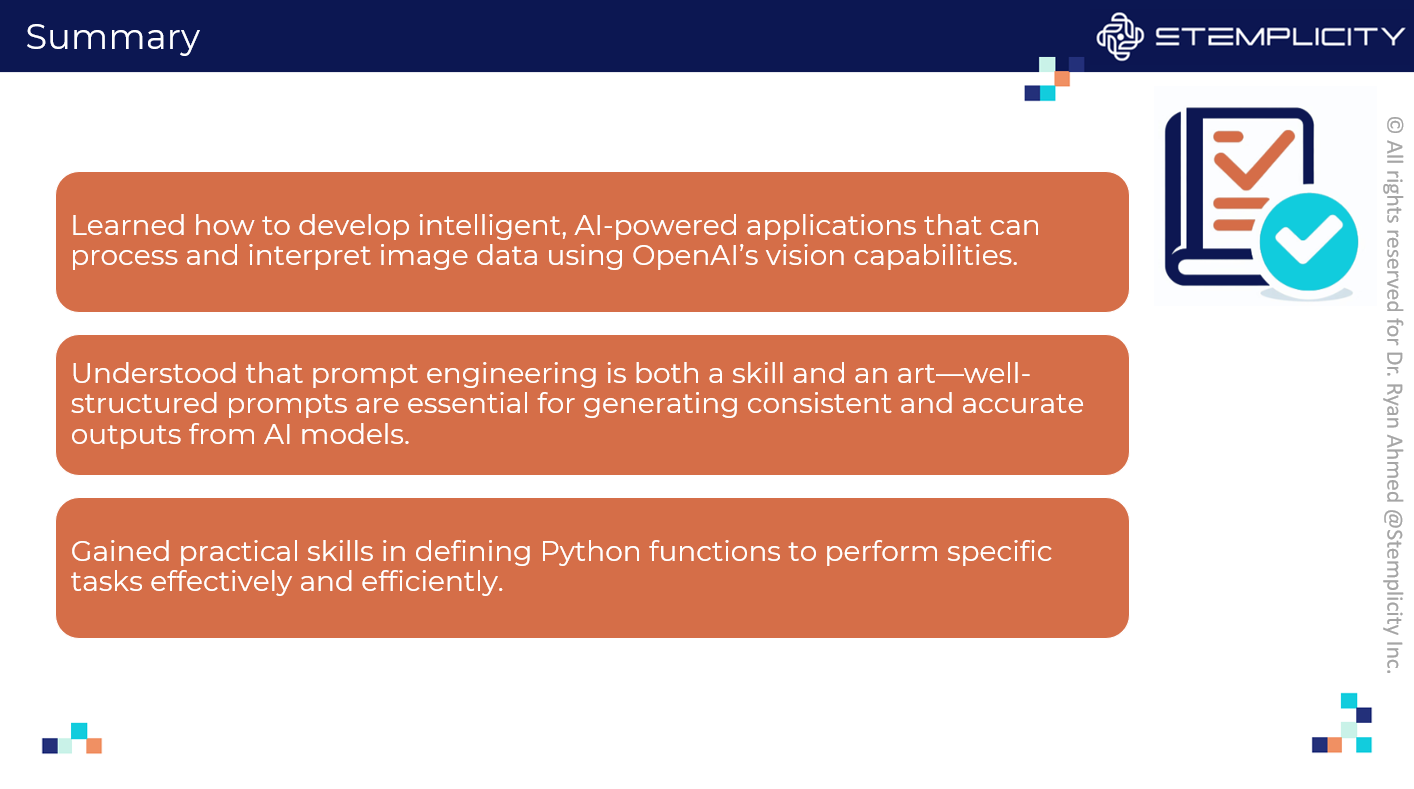

- **Would love to connect with everyone on LinkedIn: www.linkedin.com/in/dr-ryan-ahmed**

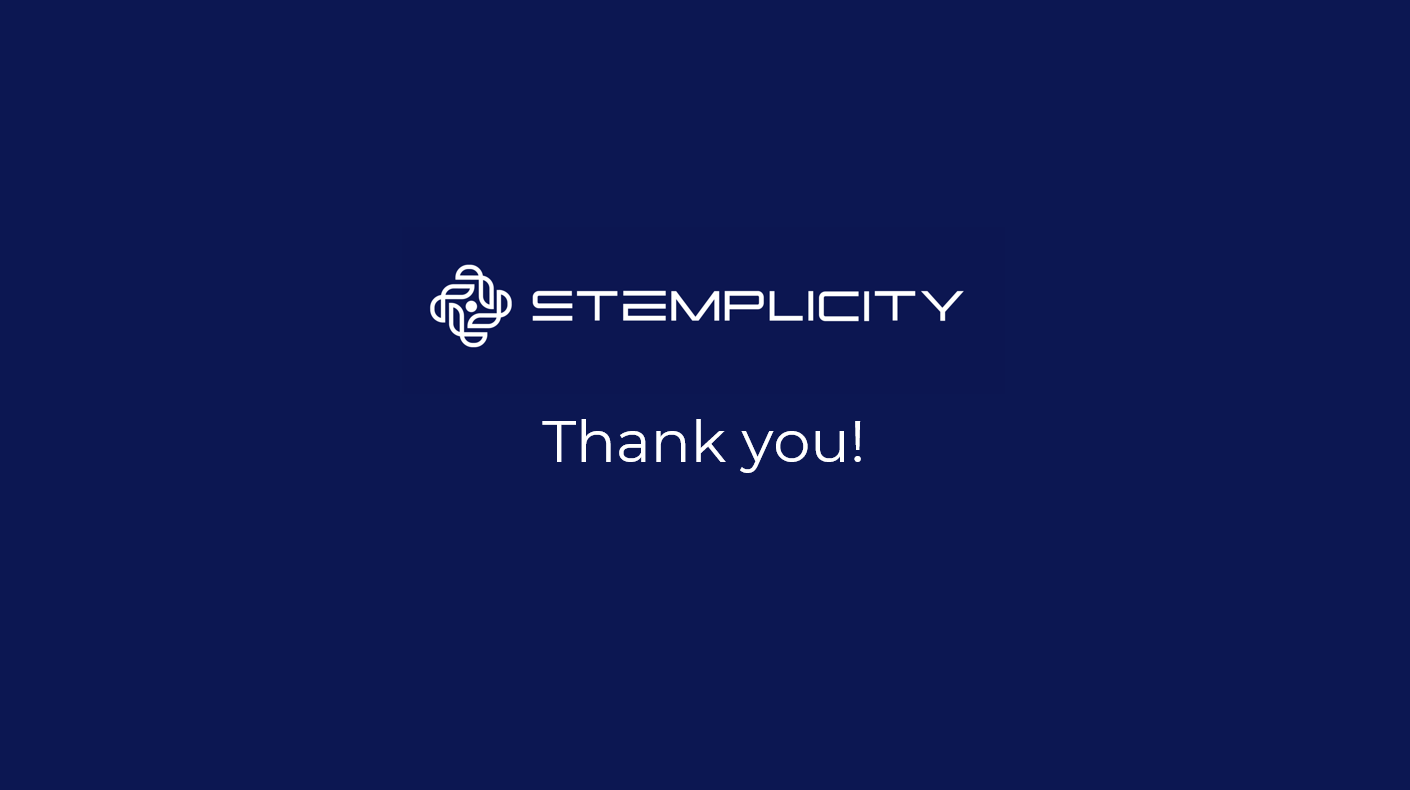